# The Product Pricer

LLM model that can estimate how much a product costs, from its product description only.


## Data Curation

The dataset is here:  
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023

And the folder with all the product datasets is here:  
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/tree/main/raw/meta_categories


***Note:-*** This notebook creates a smaller dataset for Home Appliances only, to keep training fast and costs low.

In [5]:
# imports

import os
import random
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
from items import Item
from loaders import ItemLoader
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np
import pickle

In [6]:
%matplotlib inline

***Note:-*** The loaders.py has some useful helper and utility function.

In [7]:
# Uncomment the products if a larger product dataset is needed to train the model

dataset_names = [
    # "Automotive",
    # "Electronics",
    # "Office_Products",
    # "Tools_and_Home_Improvement",
    # "Cell_Phones_and_Accessories",
    # "Toys_and_Games",
    "Appliances",
    # "Musical_Instruments",
]

In [9]:
items = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load())

Loading dataset Appliances


  0%|                                                                                           | 0/95 [00:31<?, ?it/s]


BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

In [ ]:
print(f"A grand total of {len(items):,} items")

In [ ]:
items[0].prompt

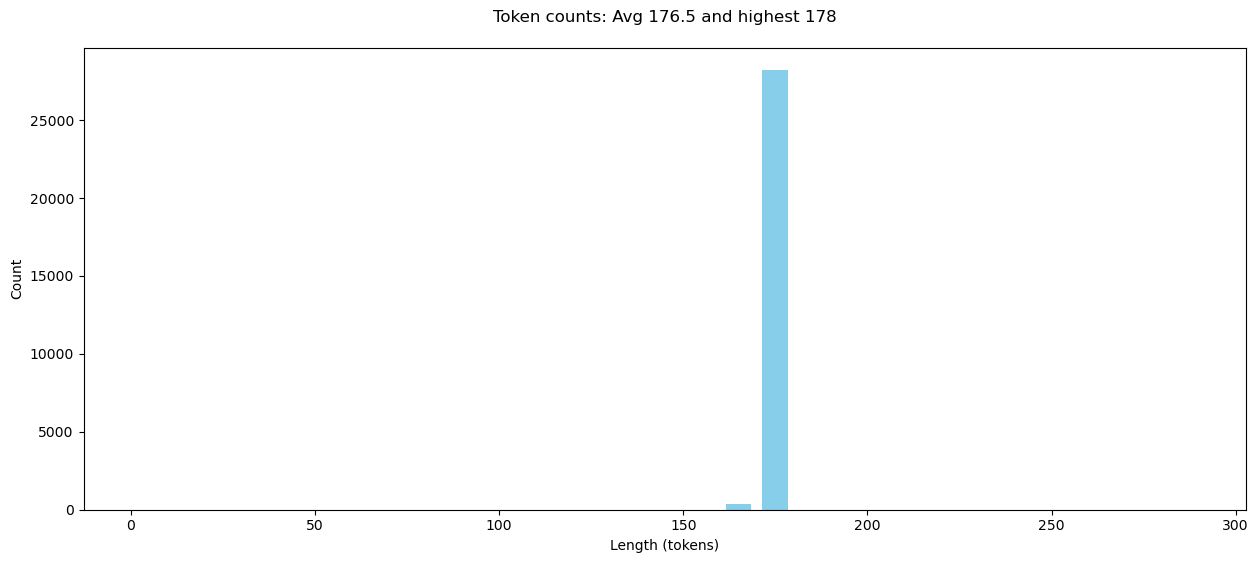

In [7]:
# Plot the distribution of token counts

tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="skyblue", bins=range(0, 300, 10))
plt.show()

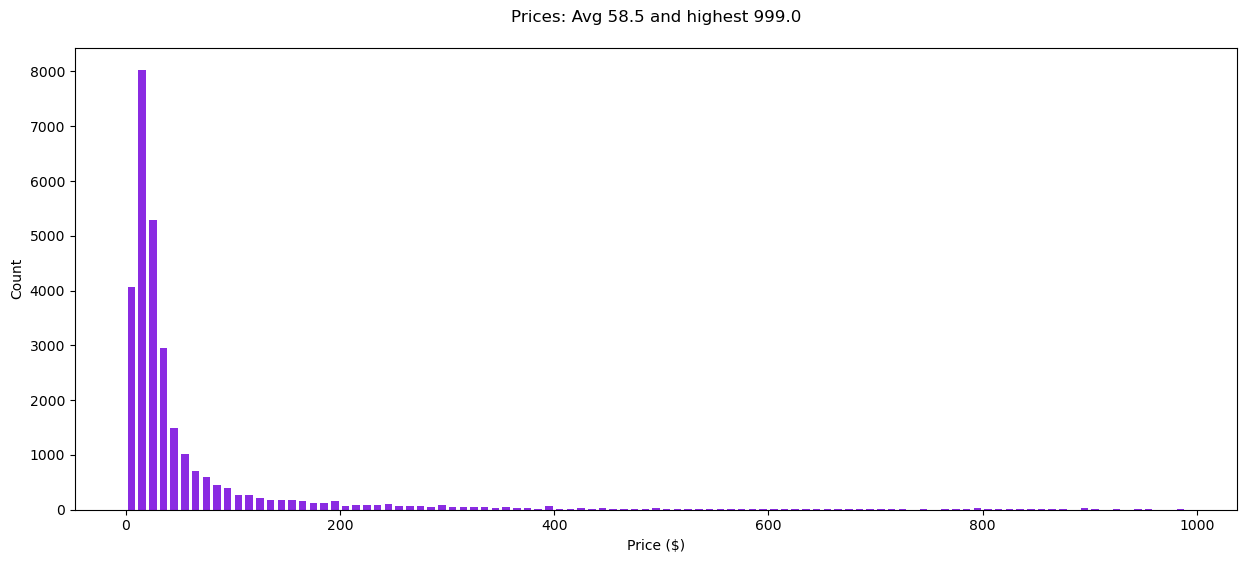

In [8]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

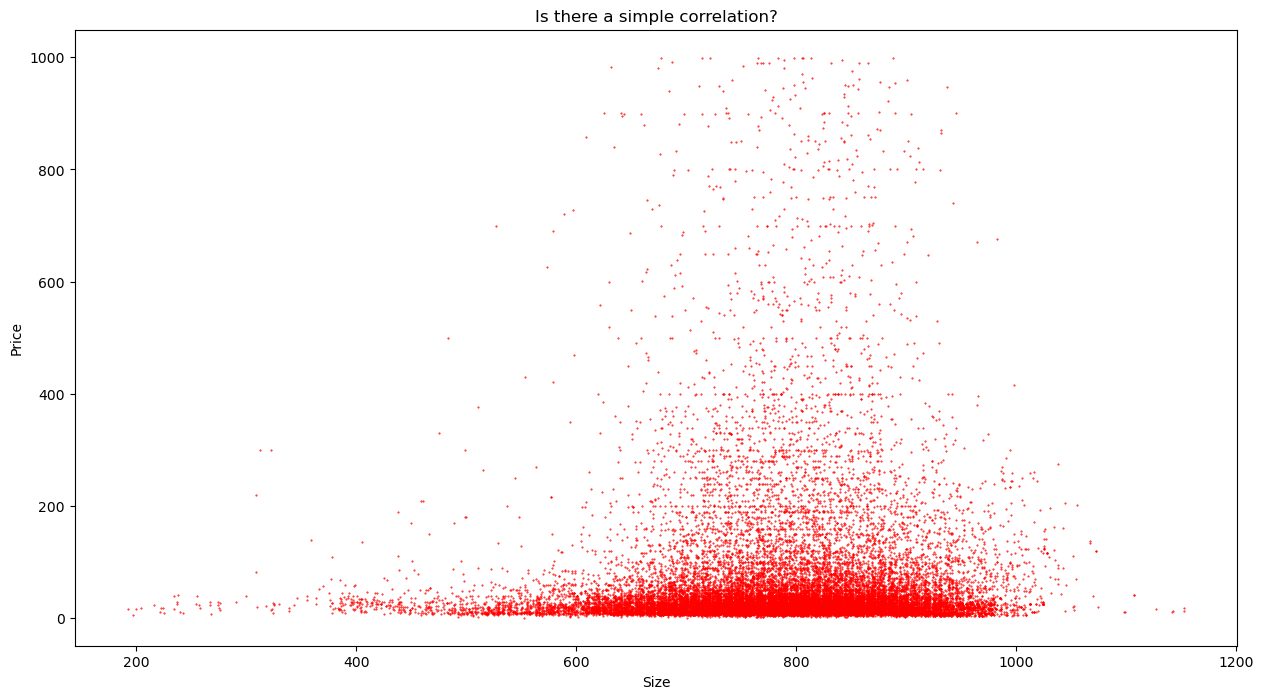

In [9]:
# How does the price vary with the character count of the prompt?

sample = items

sizes = [len(item.prompt) for item in sample]
prices = [item.price for item in sample]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(sizes, prices, s=0.2, color="red")

# Add labels and title
plt.xlabel('Size')
plt.ylabel('Price')
plt.title('Is there a simple correlation?')

# Display the plot
plt.show()

### Break down the data into a training, test and validation dataset.


In [10]:
random.seed(42)
random.shuffle(sample)
train = sample[:25_000]
test = sample[25_000:27_000]
print(f"Divided into a training set of {len(train):,} items and test set of {len(test):,} items")

Divided into a training set of 25,000 items and test set of 2,000 items


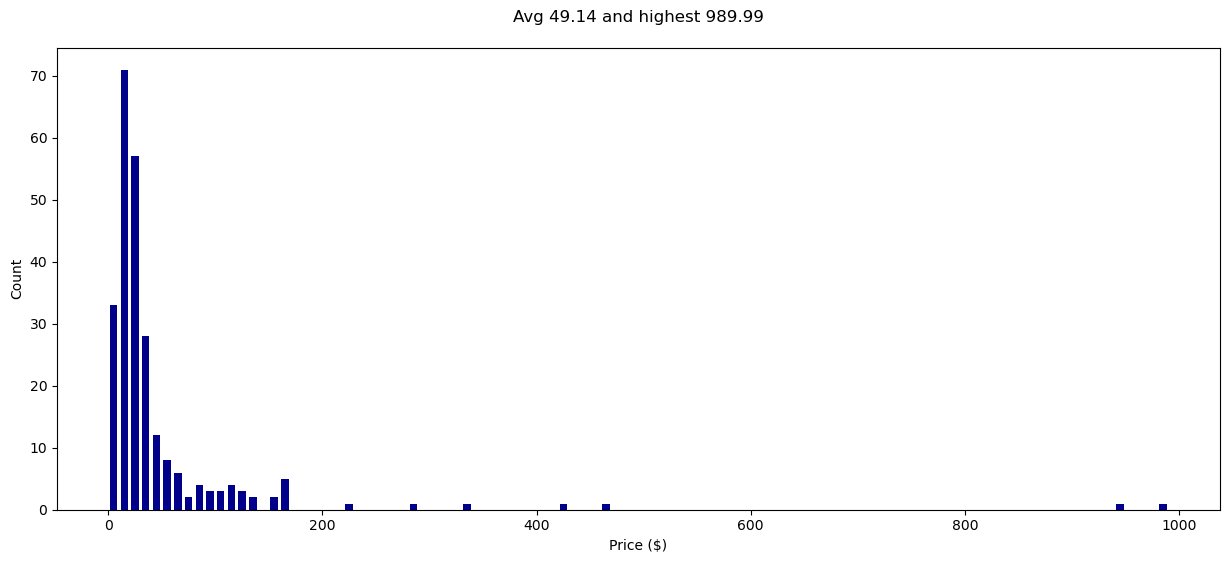

In [11]:
# Plot the distribution of prices in the first 250 test points

prices = [float(item.price) for item in test[:250]]
plt.figure(figsize=(15, 6))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

### Upload the dataset to Huggingface and create pickle file

Convert to prompts and upload to HuggingFace hub

In [27]:
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

In [33]:
# Create a Dataset from the lists

train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [36]:
DATASET_NAME = "sahidul-hf1/pricer-data"
dataset.push_to_hub(DATASET_NAME, private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/25 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/sahidul-hf/lite-data/commit/a66d9ff6ba7c7dec61f901f37064f4ea7bbb67f6', commit_message='Upload dataset', commit_description='', oid='a66d9ff6ba7c7dec61f901f37064f4ea7bbb67f6', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/sahidul-hf/lite-data', endpoint='https://huggingface.co', repo_type='dataset', repo_id='sahidul-hf/lite-data'), pr_revision=None, pr_num=None)

In [12]:
# Pickle the training and test dataset

with open('train_lite.pkl', 'wb') as file:
    pickle.dump(train, file)

with open('test_lite.pkl', 'wb') as file:
    pickle.dump(test, file)